In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns
# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float('nan')])

def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert(np.sum(activations) == row.number_activations or row.error)
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d['attack_space'] = row['strategy'].split('-')[0]
    d['policy'] = '-'.join(row['strategy'].split('-')[1:])
    d['attacker_compute'] = rcompute[0]
    d['attacker_relative_activations'] = ractivations[0]
    d['attacker_relative_reward'] = rreward[0]
    d['attacker_gain'] = rreward[0] - ractivations[0]
    d['attacker_reward'] = reward[0]
    d['attacker_reward_per_time'] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d['da_observed_pow_interval'] = row.ca_time / (row.ca_height * row.k)
    d['da_target_pow_interval'] = 1
    d['da_ca_time'] = row.ca_time / d['da_observed_pow_interval'] * d['da_target_pow_interval']
    d['da_attacker_reward_per_time'] = reward[0] / d['da_ca_time']
    return d

df=df.join(df.apply(expand, axis=1, result_type='expand'))

d = df[df.protocol == "george"]
d = d[(d.incentive_scheme == 'constant') | (d.incentive_scheme == 'discount')]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_observed_pow_interval', 'da_target_pow_interval', 'da_ca_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [2]:
d.pivot(index=['attacker_compute', 'k'], columns=['strategy', 'incentive_scheme'], values='attacker_relative_reward')

strategy             private-override-catchup            \
incentive_scheme                     constant  discount   
attacker_compute k                                        
0.10             1                   0.033939  0.033939   
                 2                   0.026385  0.026385   
                 4                   0.015777  0.015294   
                 8                   0.016111  0.014917   
                 16                  0.018063  0.016763   
                 32                  0.019017  0.017872   
                 64                  0.024823  0.023360   
                 128                 0.046652  0.044581   
0.20             1                   0.133083  0.133083   
                 2                   0.107067  0.107067   
                 4                   0.080762  0.077346   
                 8                   0.083455  0.076440   
                 16                  0.104700  0.095800   
                 32                  0.123770  0.113830   
                 64                  0.177951  0.170899   
                 128                 0.220388  0.217310   
0.25             1                   0.200782  0.200782   
                 2                   0.168552  0.168552   
                 4                   0.162114  0.155086   
                 8                   0.143296  0.132602   
                 16                  0.171263  0.158054   
                 32                  0.215495  0.205275   
                 64                  0.285714  0.281387   
                 128                 0.302436  0.300561   
0.33             1                   0.312022  0.312022   
                 2                   0.297431  0.297431   
                 4                   0.274625  0.267630   
                 8                   0.303355  0.290228   
                 16                  0.359977  0.349452   
                 32                  0.410610  0.411096   
                 64                  0.453567  0.455561   
                 128                 0.451209  0.451662   
0.40             1                   0.462617  0.462617   
                 2                   0.448505  0.448505   
                 4                   0.425931  0.420197   
                 8                   0.456981  0.450530   
                 16                  0.515436  0.522009   
                 32                  0.600412  0.626600   
                 64                  0.606153  0.629818   
                 128                 0.640459  0.671873   
0.45             1                   0.618720  0.618720   
                 2                   0.602318  0.602318   
                 4                   0.555752  0.552762   
                 8                   0.568141  0.569706   
                 16                  0.645680  0.672368   
                 32                  0.702806  0.747653   
                 64                  0.713053  0.764982   
                 128                 0.712434  0.776381   
0.50             1                   0.801753  0.801753   
                 2                   0.820209  0.820209   
                 4                   0.851413  0.854425   
                 8                   0.836134  0.848082   
                 16                  0.790593  0.822467   
                 32                  0.746830  0.798321   
                 64                  0.753403  0.815586   
                 128                 0.752855  0.822129   

strategy             private-override-block            \
incentive_scheme                   constant  discount   
attacker_compute k                                      
0.10             1                 0.032851  0.032851   
                 2                 0.023215  0.023215   
                 4                 0.018102  0.017115   
                 8                 0.011354  0.010525   
                 16                0.014372  0.013421   
                 32                0.018127  0.016776   
     

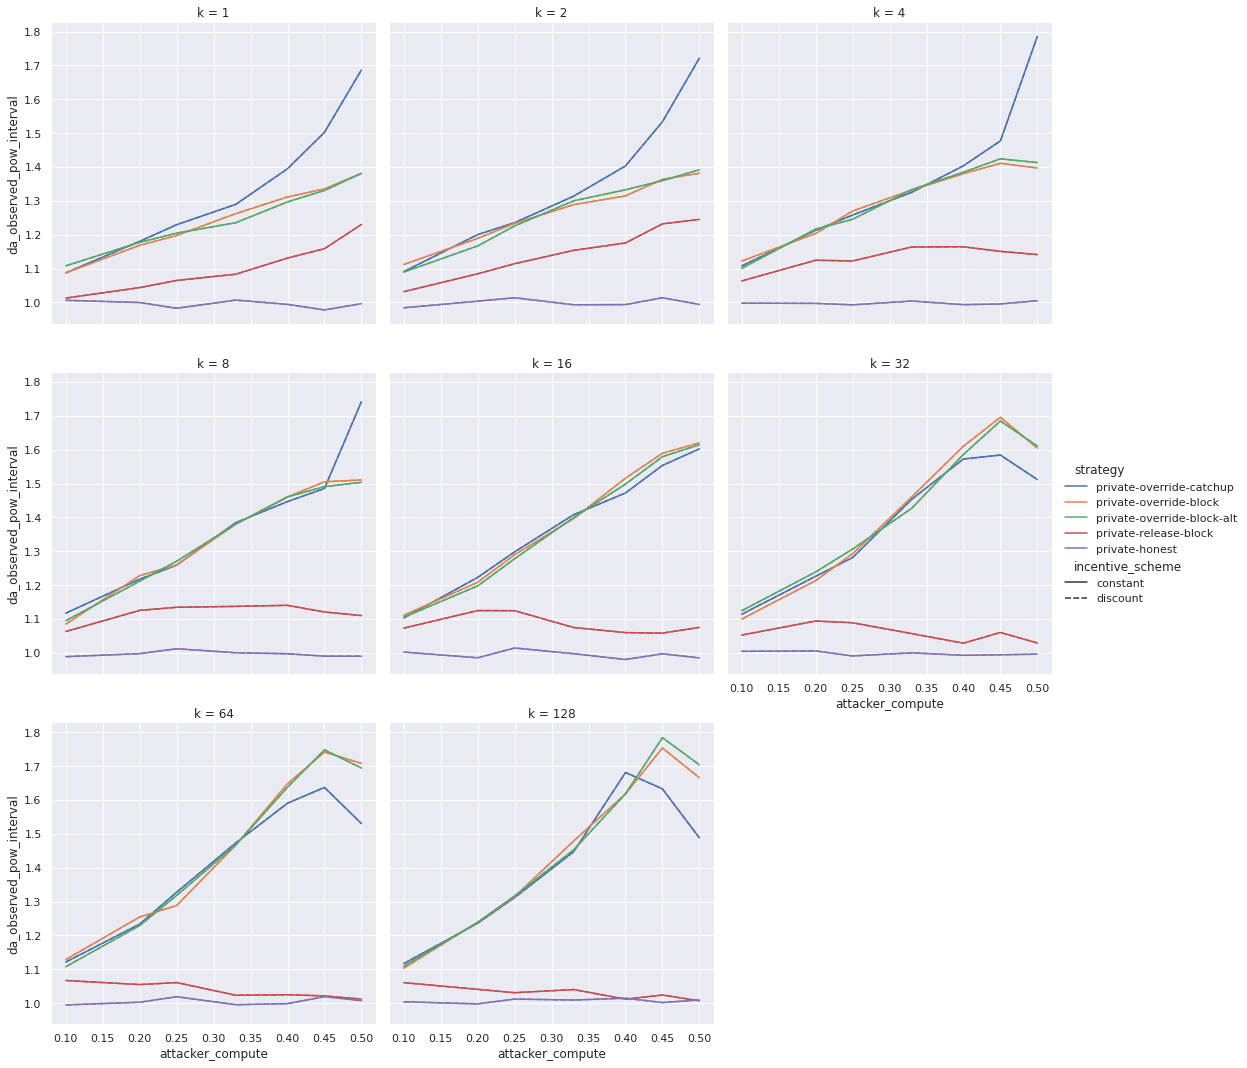

In [3]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute", y="da_observed_pow_interval", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)

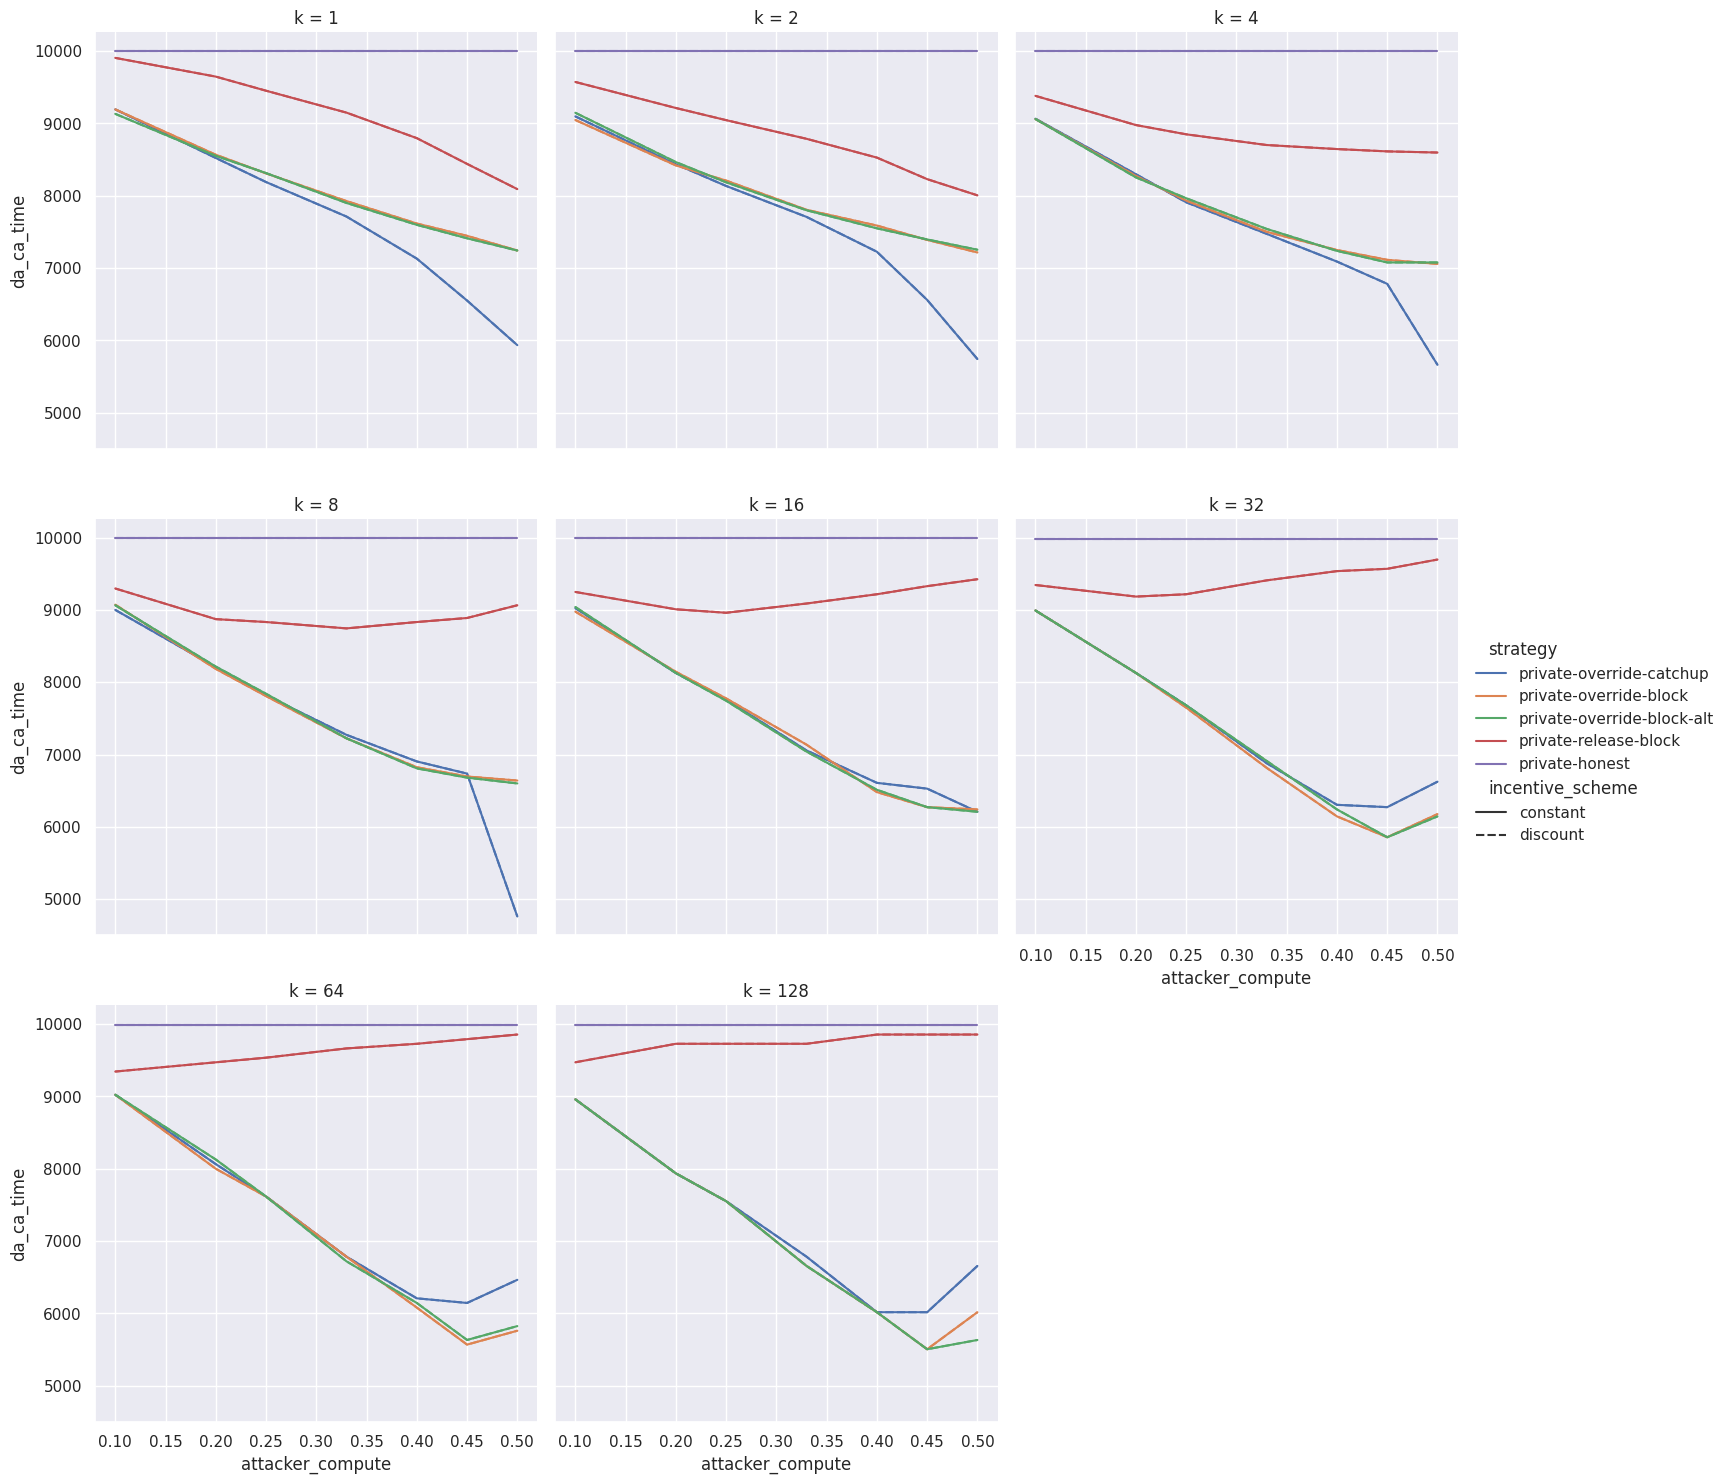

In [4]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute", y="da_ca_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)

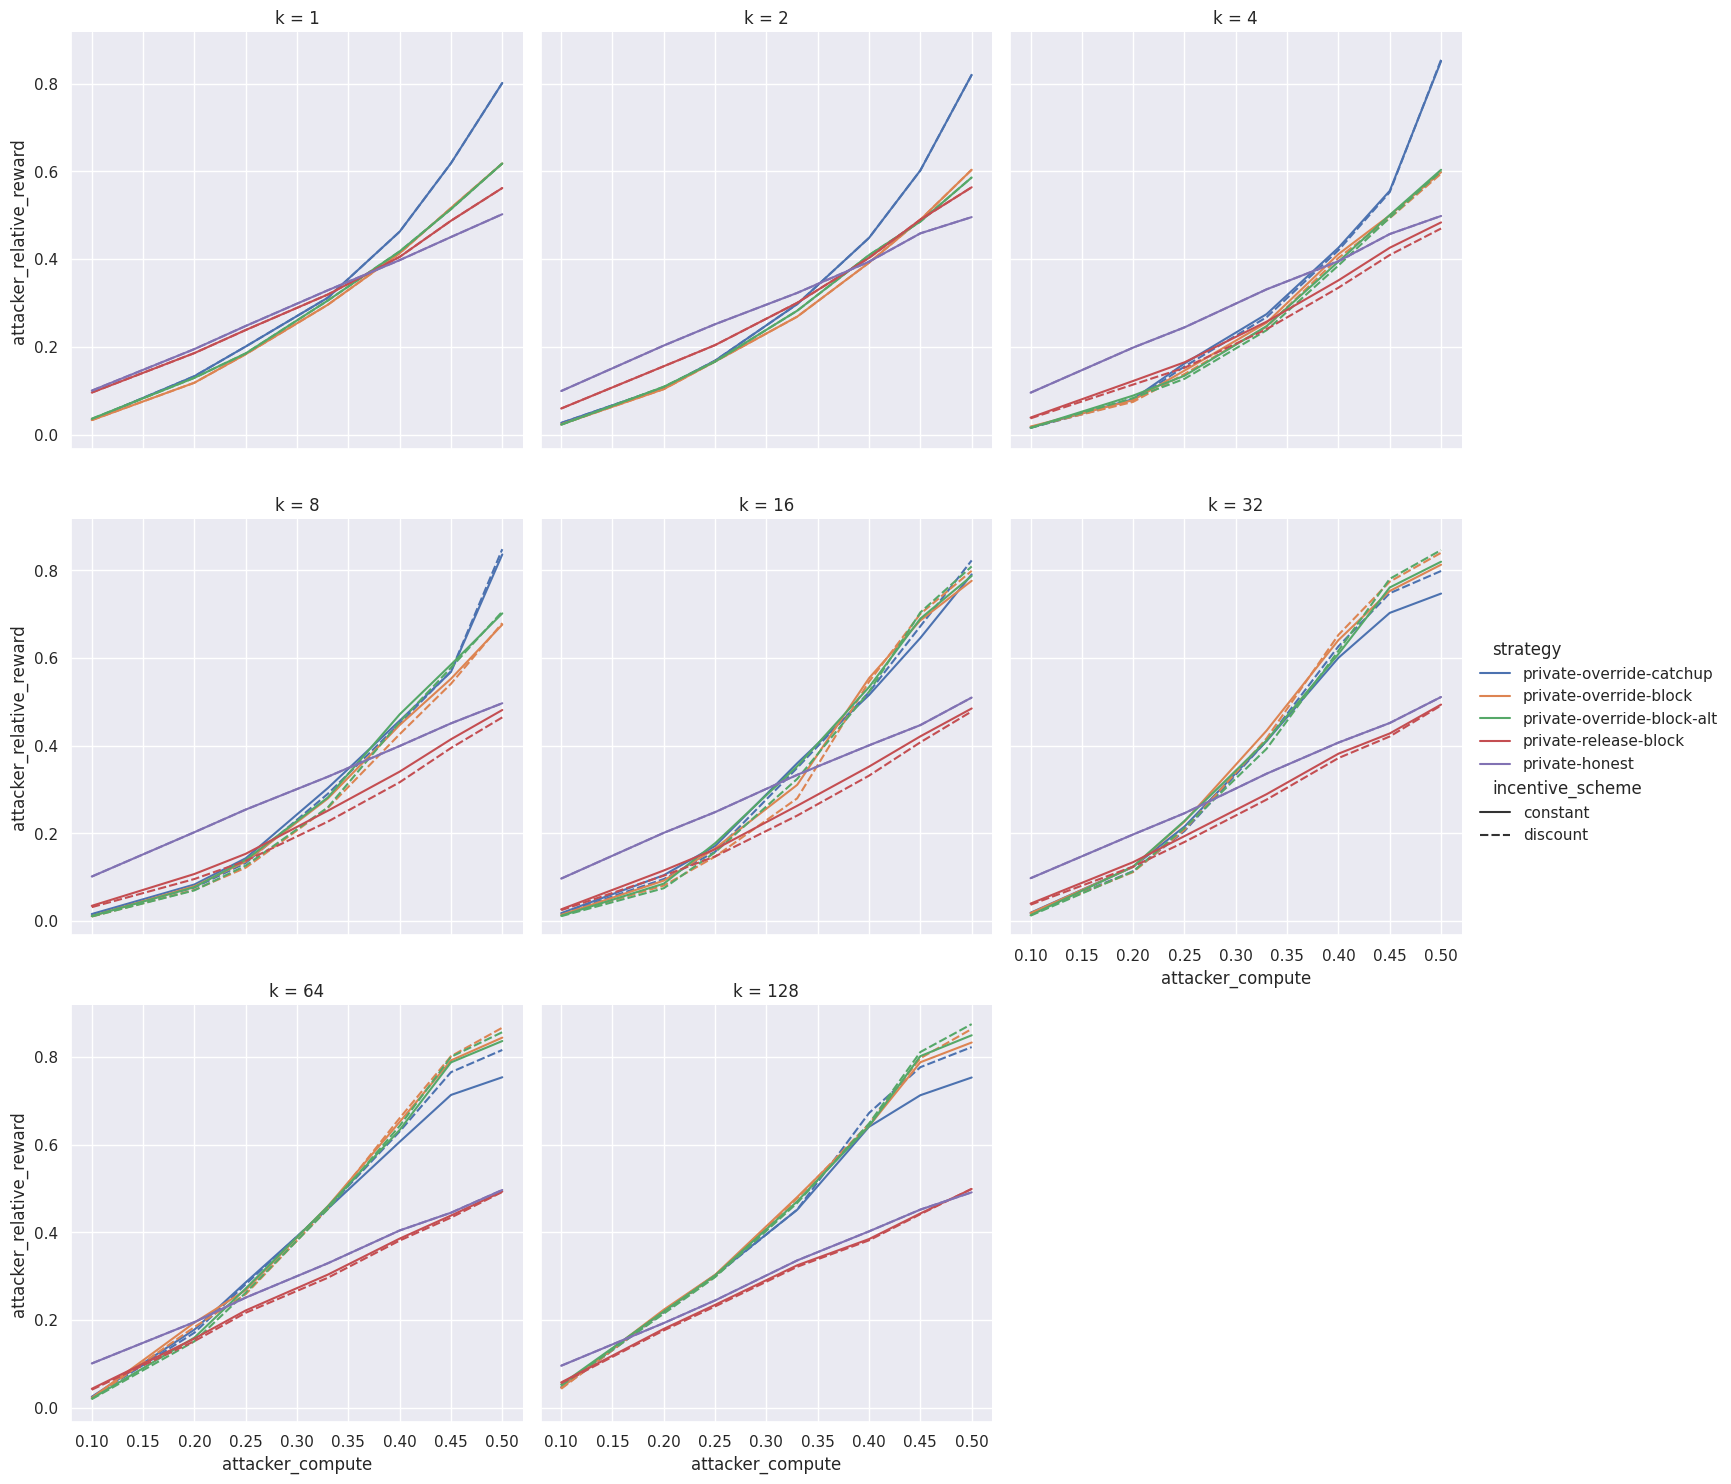

In [5]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute", y="attacker_relative_reward", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

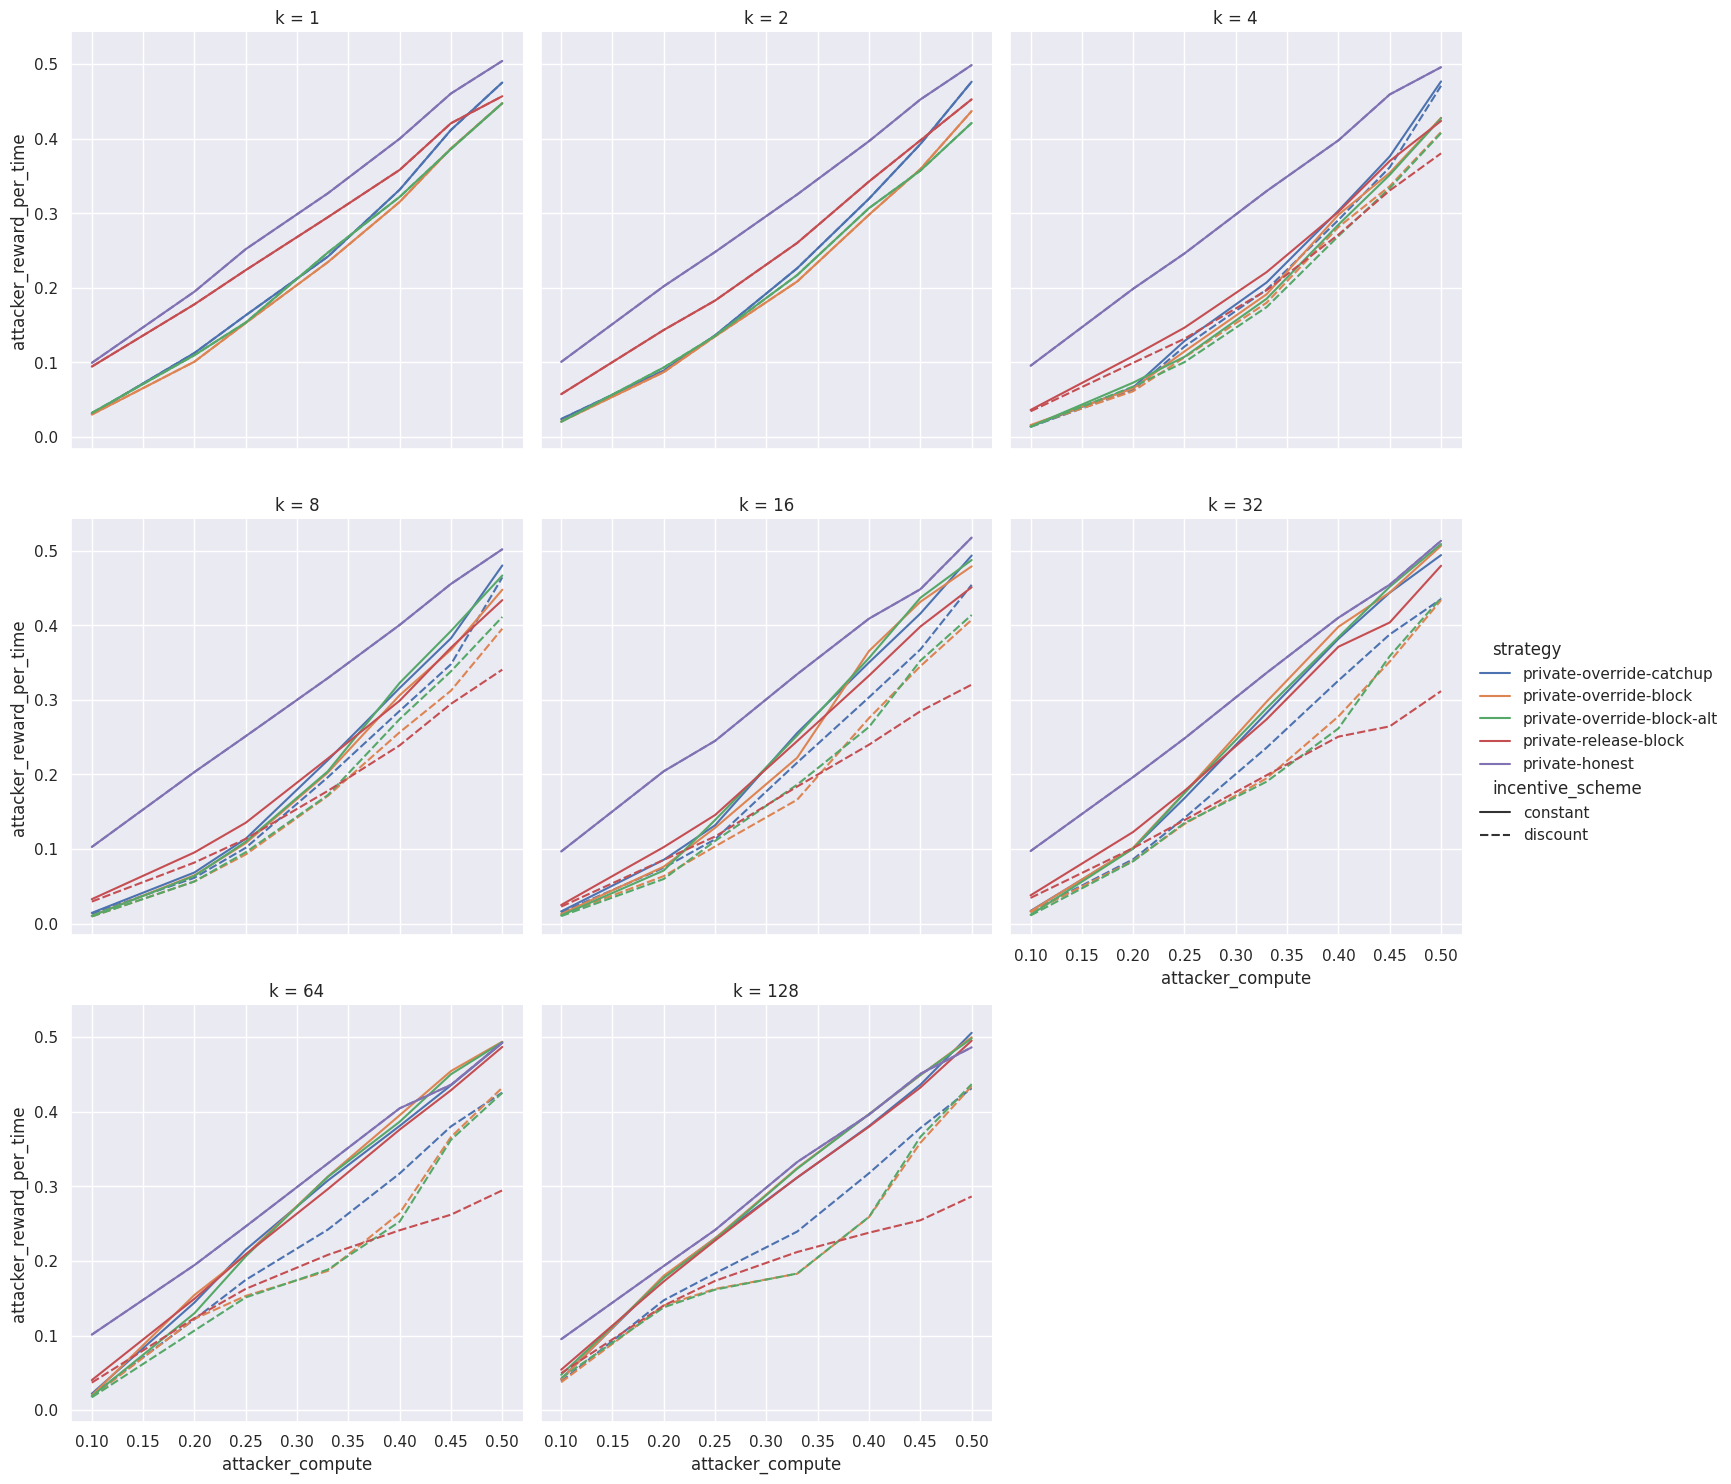

In [6]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute", y="attacker_reward_per_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

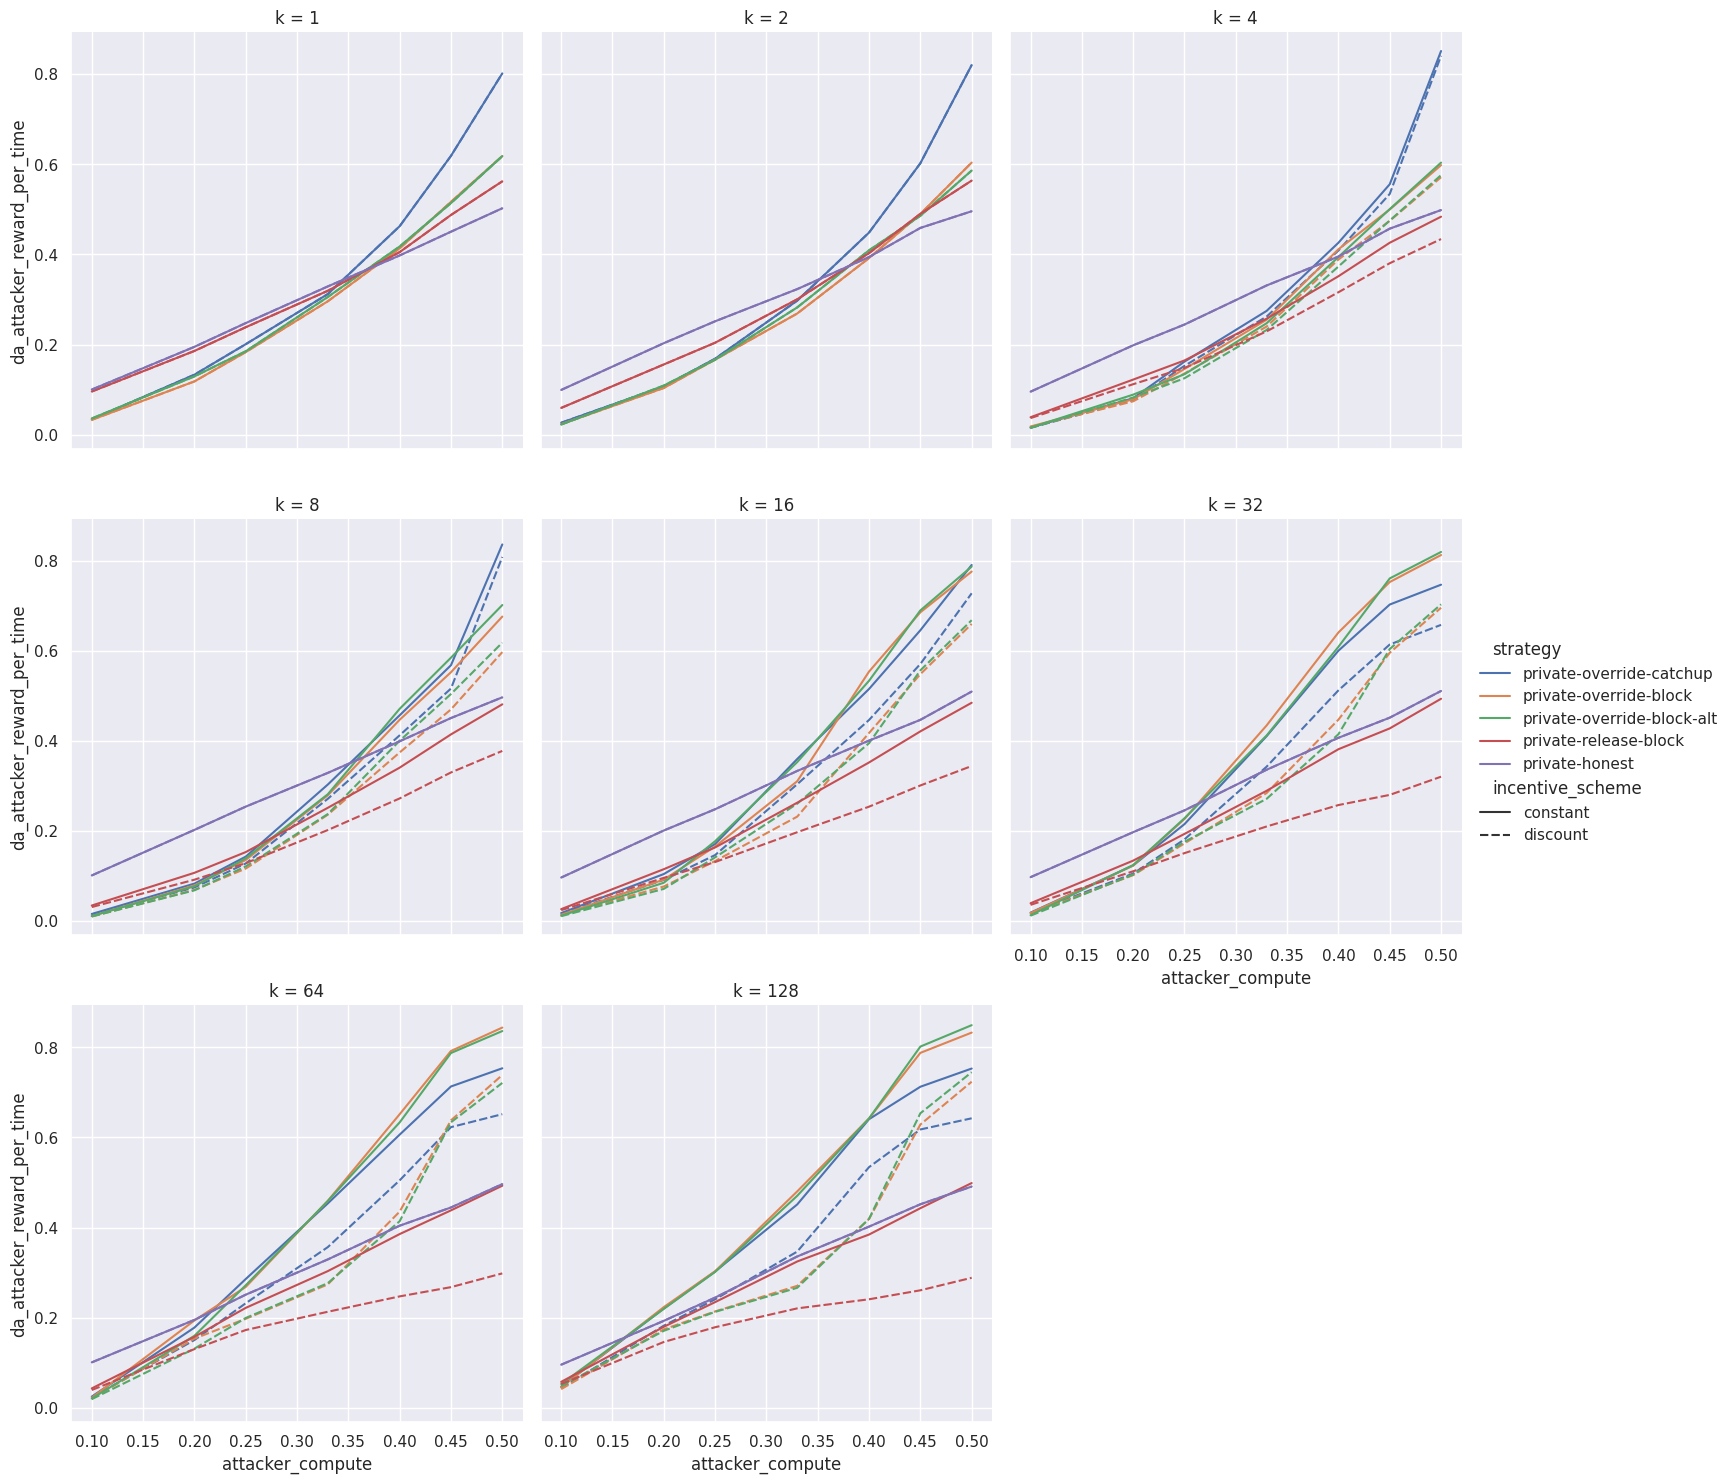

In [7]:
ax = sns.relplot(
    data=d[d.attack_space == "private"],
    x="attacker_compute", y="da_attacker_reward_per_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

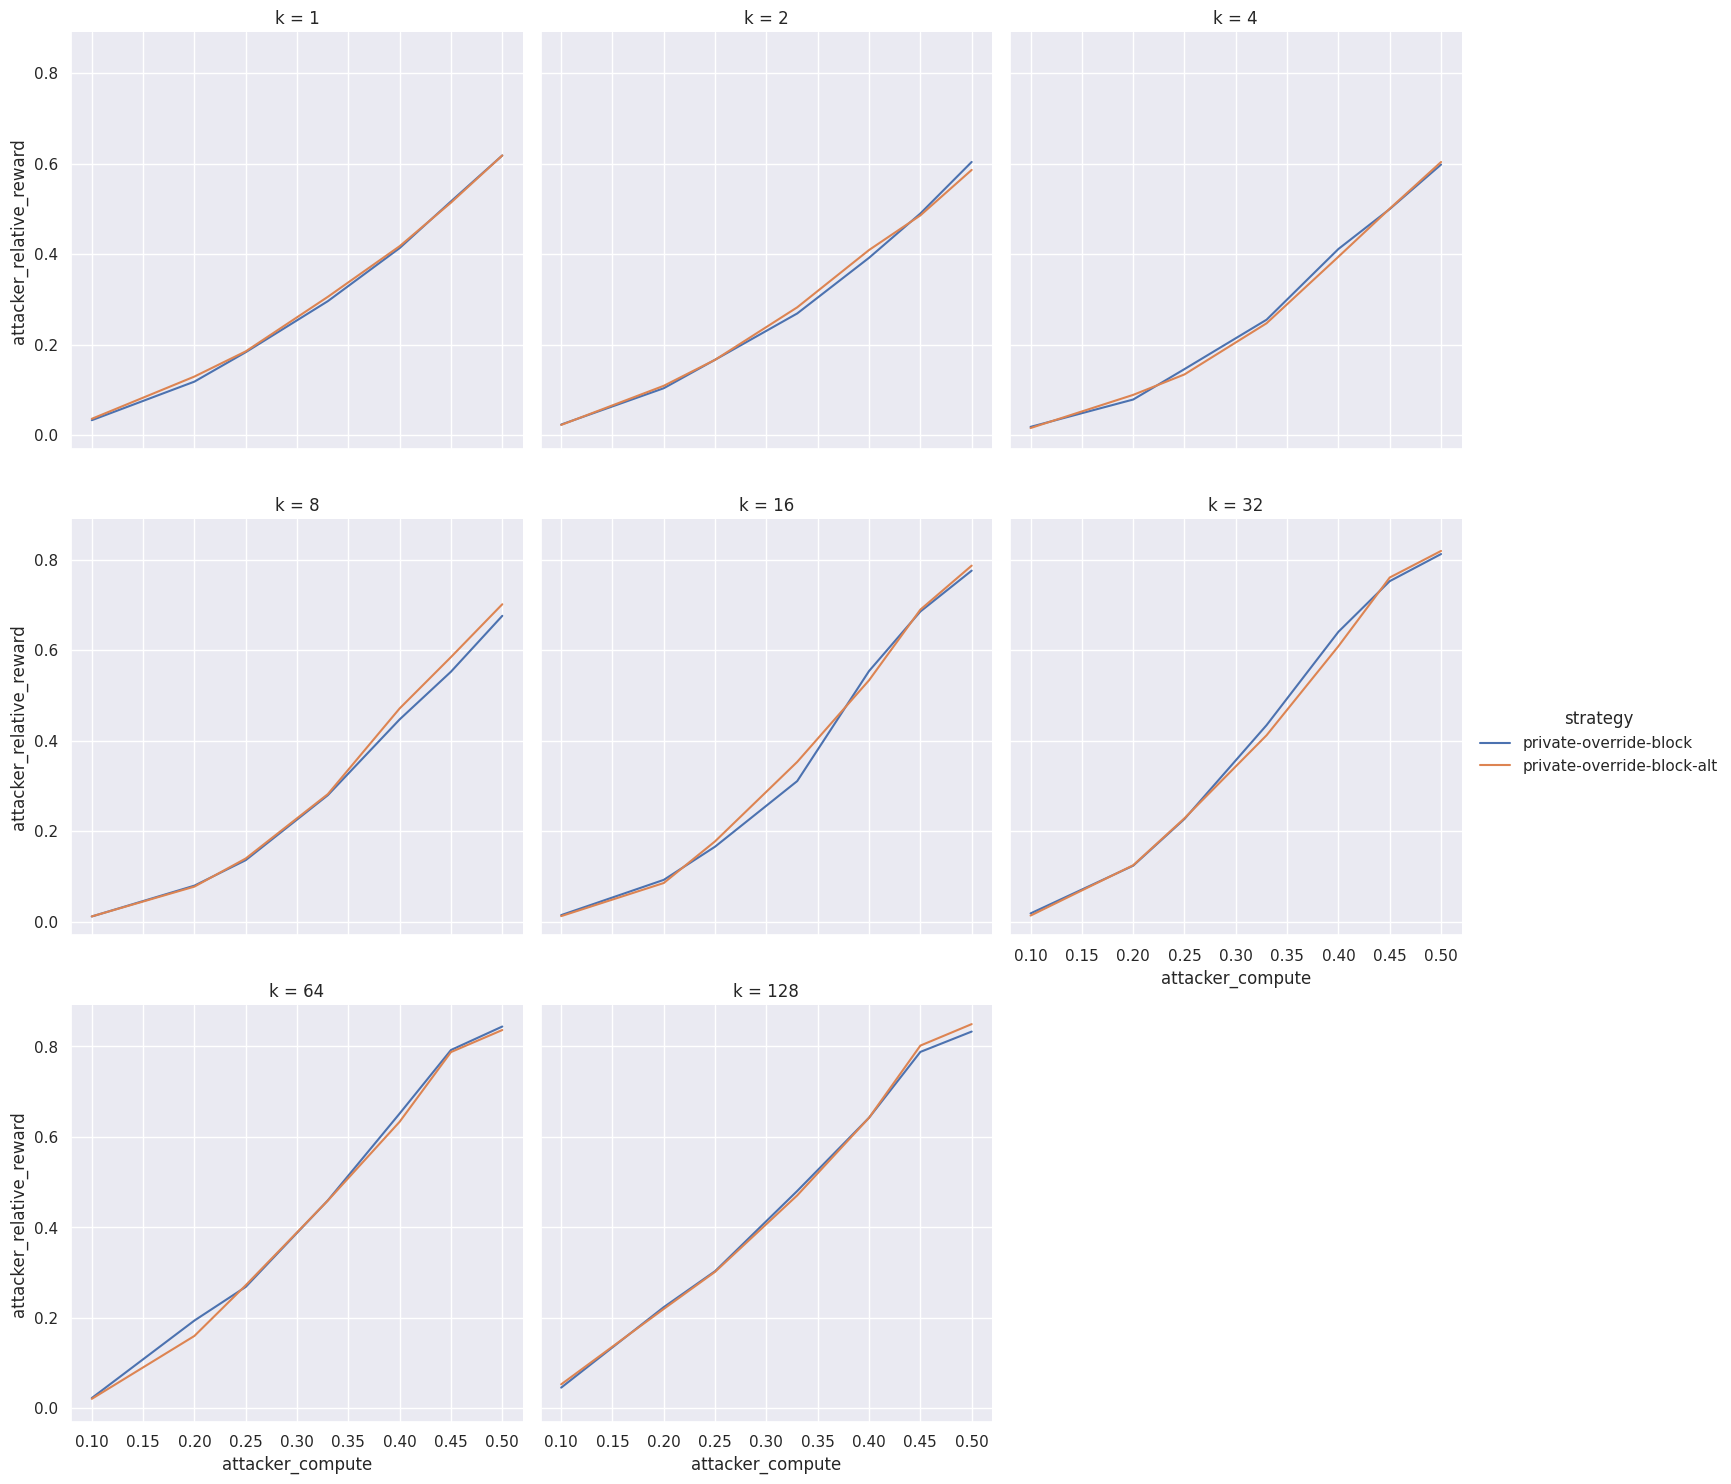

In [8]:
# does numerical implementation line up with non-numerical implementation of policiy?
dd = d
dd = dd[(dd['strategy']=='private-override-block') | (dd['strategy']=='private-override-block-alt')]
dd = dd[(dd['incentive_scheme']=='constant')]
sns.relplot(
    data=dd,
    x="attacker_compute", y="attacker_relative_reward", col="k", col_wrap=3,
    hue="strategy", kind="line",
)
# It does line up!

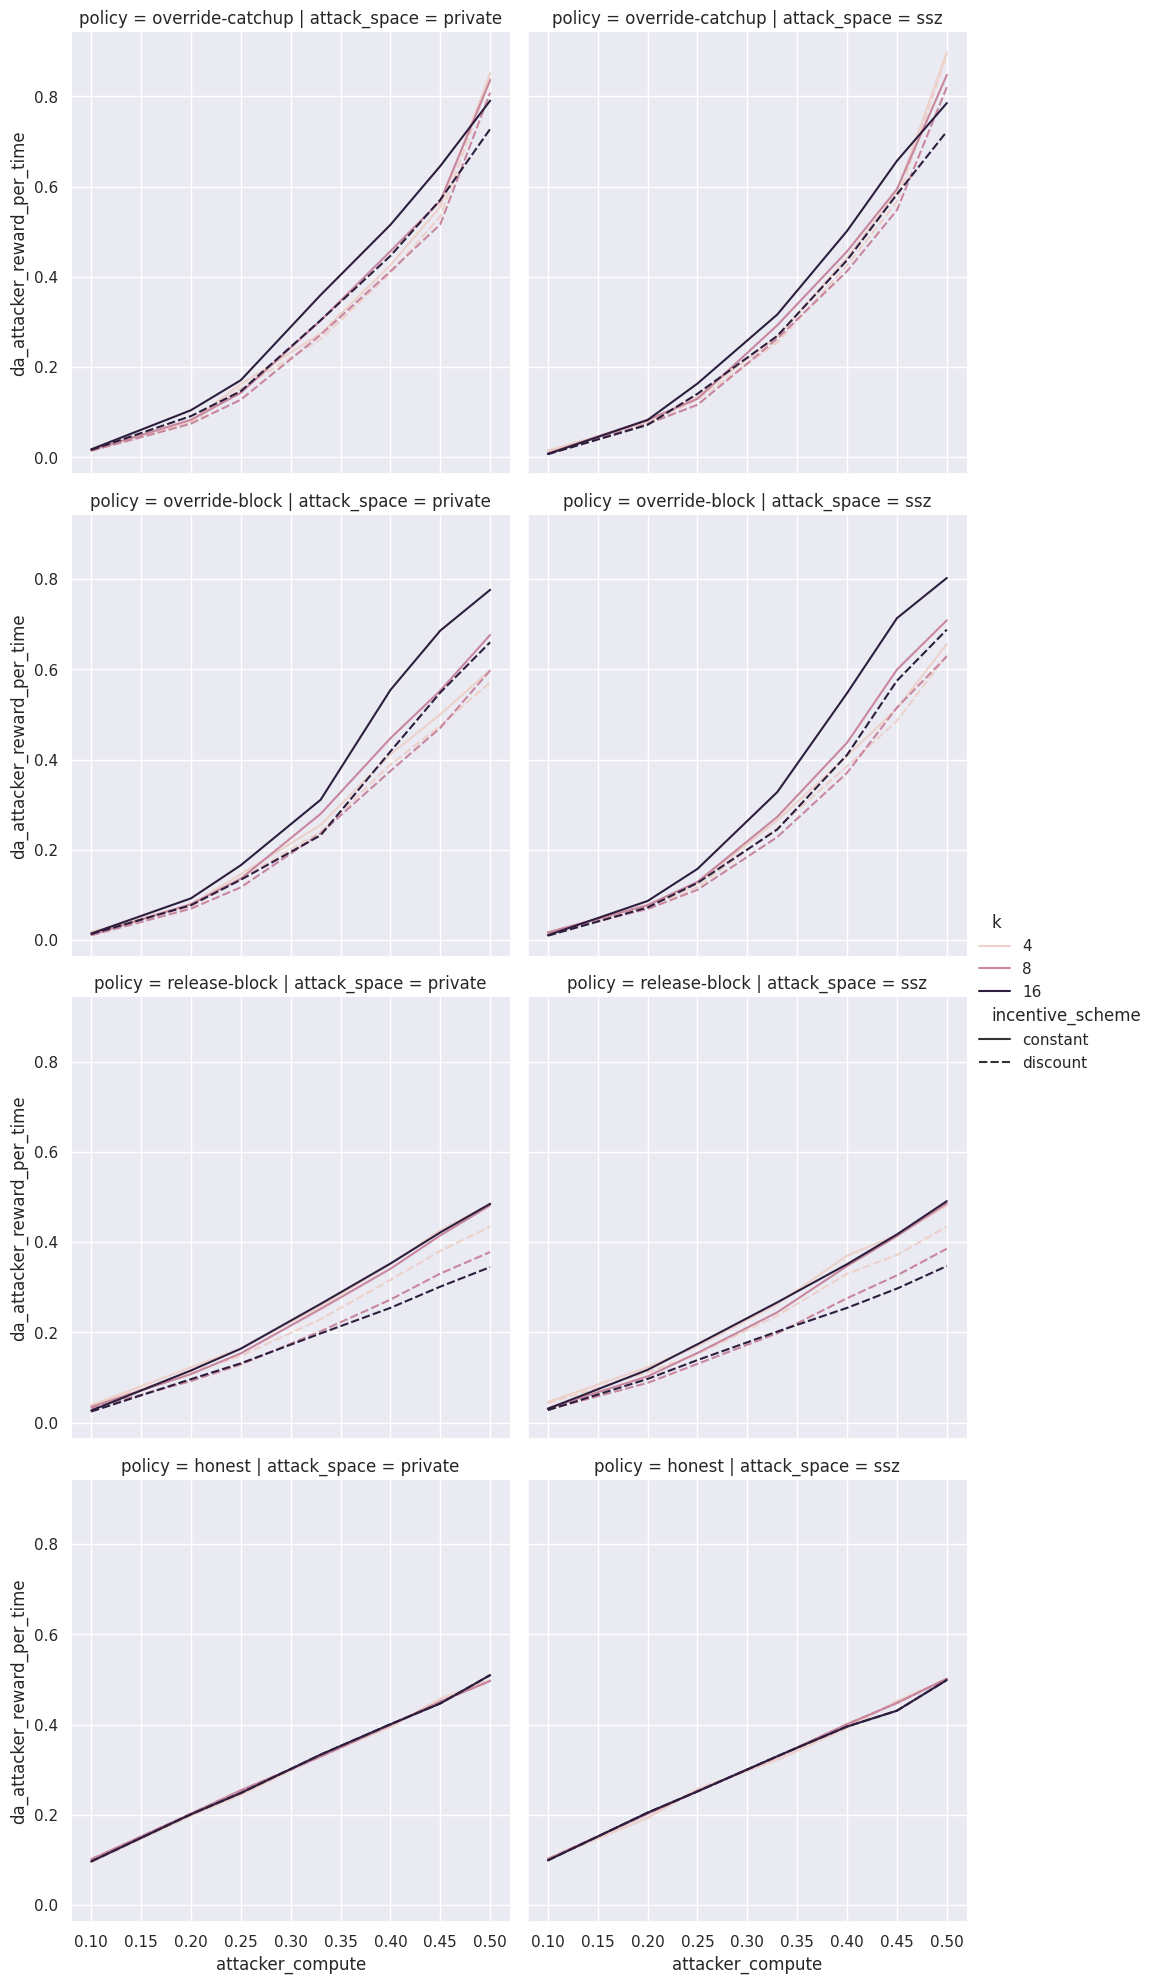

In [9]:
ax = sns.relplot(
    data=d[ [k in [4,8,16] and policy != "override-block-alt" for k, policy in zip(d.k, d.policy)]],
    x="attacker_compute", y="da_attacker_reward_per_time", col="attack_space", row="policy",
    hue="k", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")